In [2]:
%matplotlib inline
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt  
import seaborn as sns

import random

import string
import spacy
from spacy.lang.en import English
import en_core_web_sm
from spacy import displacy
from sklearn.metrics.pairwise import cosine_similarity

#Topic Modeling
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore") #category=DeprecationWarning


import os
from nlp_preprocessing import *

In [3]:
data_path = 'data'
file_name = 'MyA_TY2018_all.csv'
cra_data = pd.read_csv(os.path.join(data_path, file_name))
print(cra_data.shape)
cra_data.head()

(66260, 107)


,Internal ID,Quarter,Language answered,Accessed date,First answer date,Last answer date,Submitted date,Status,"What was the main purpose of your visit today? Please choose one option only. The list represents broad categories, and you may be asked to further specify the main reason why you visited today.",Please specify:,...,What is the highest level of education you have completed?,Would you be willing to indicate in which of the following age categories you belong?,What language do you speak most often at home?,Which of the following categories best describes your current employment status?,"Which of the following categories best represents your most recent annual household income, before taxes?",Are you an Aboriginal person?,Are you a person with a disability?,Are you a member of a visible minority group?,From what type of device did you access My Account today?,Please specify:3
0,1,Q4,EN,1/4/2018,1/4/2018,1/4/2018,1/4/2018,Submitted,Benefits and tax credits information,NaN,...,College/vocational/technical school,35 to 49,English,Not in the workforce,"$20,000 to under $40,000",No,Yes,No,Desktop or laptop computer,NaN
1,2,Q4,EN,1/4/2018,1/4/2018,1/4/2018,1/4/2018,Submitted,Benefits and tax credits information,NaN,...,University graduate,35 to 49,English,Self-employed,"$80,000 to under $100,000",No,Yes,No,Desktop or laptop computer,NaN
2,3,Q4,EN,1/4/2018,1/4/2018,1/4/2018,1/4/2018,Submitted,Tax returns,NaN,...,Some high school,50 to 54,English,Not in the workforce,"Under $20,000",No,No,No,Desktop or laptop computer,NaN
3,4,Q4,EN,1/4/2018,1/4/2018,1/4/2018,1/4/2018,Submitted,Accounts and payments,NaN,...,Some high school,55 to 64,English,Other,"Under $20,000",No,Yes,No,Desktop or laptop computer,NaN
4,5,Q4,EN,1/4/2018,1/4/2018,1/4/2018,1/4/2018,Submitted,RRSP and TFSA,NaN,...,Some university,18 to 34,English,Working full-time (35+ hours per week),"$80,000 to under $100,000",No,No,Yes,Desktop or laptop computer,NaN


In [8]:
cra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66260 entries, 0 to 66259
Columns: 107 entries, Internal ID to Please specify:3
dtypes: int64(1), object(106)
memory usage: 54.1+ MB


In [9]:
cra_data.columns

Index(['Internal ID', 'Quarter', 'Language answered', 'Accessed date',
       'First answer date', 'Last answer date', 'Submitted date', 'Status',
       'What was the main purpose of your visit today? Please choose one option only. The list represents broad categories, and you may be asked to further specify the main reason why you visited today.',
       'Please specify:',
       ...
       'What is the highest level of education you have completed?',
       'Would you be willing to indicate in which of the following age categories you belong?',
       'What language do you speak most often at home?',
       'Which of the following categories best describes your current employment status?',
       'Which of the following categories best represents your most recent annual household income, before taxes?',
       'Are you an Aboriginal person?', 'Are you a person with a disability?',
       'Are you a member of a visible minority group?',
       'From what type of device did you access

#Cleaning steps:

1. language answered = EN
2. cra_data['Accessed date'] == cra_data['First answer date'] except for 55 rows -- only keep one of this date
3. submitted is same in all row == Submitted
4. rename columns name : what was the main purpose ....

In [26]:
cra_data.rename(columns={'What was the main purpose of your visit today? Please choose one option only. The list represents broad categories, and you may be asked to further specify the main reason why you visited today.':'Main_purpose'}, inplace=True)

In [23]:
len([n for n in cra_data['Accessed date'] == cra_data['Submitted date'] if n == False])


354

In [31]:
#this row is needed some cleaning -> NOA = notice of assessment ....T4, t-4 ,,... // is it informative??
print(cra_data['Please specify:'].count()) #not null values -- maybe we can use it only when user chose other
cra_data['Please specify:'].value_counts()

2542


Notice of Assessment                                26
T4                                                  13
notice of assessment                                12
T4 slips                                            10
NOA                                                  9
                                                    ..
Information                                          1
check my TFSA room                                   1
T4's                                                 1
To check emails about my instalment payments due     1
t-4                                                  1
Name: Please specify:, Length: 2326, dtype: int64

In [28]:
cra_data.Main_purpose.value_counts()

Tax returns                                     19866
Benefits and tax credits information            12103
Online mail                                     10163
Accounts and payments                            9692
RRSP and TFSA                                    4710
Your personal information                        4251
Other                                            2476
Submit documents                                 1610
Proof of income statement (option "C" print)      794
Prefer not to say                                 594
Name: Main_purpose, dtype: int64

In [32]:
cra_data['You have selected "Benefits and tax credits information". Please specify:'].value_counts()

Canada child tax benefit (CCTB)        5173
GST/HST credit                         2615
Disability Tax Credit (DTC)            1195
Your information                        899
Provincial benefit                      501
Universal child care benefit (UCCB)     453
Other                                   435
View and update children in my care     333
Other provincial programs               252
Prefer not to say                       152
Working income tax benefit (WITB)        96
Name: You have selected "Benefits and tax credits information". Please specify:, dtype: int64

In [34]:
cra_data['You have selected "Tax returns". Please specify.'].value_counts()

Notices of Assessment and Reassessment    12356
Returns                                    4728
Tax information slips (T4 and more)        1675
Other                                       668
Carryover amounts                           219
Disability tax credit                       181
Prefer not to say                            40
Name: You have selected "Tax returns". Please specify., dtype: int64

In [48]:
cra_data.iloc[:14, 70:90]

,"You have selected ""Your personal information"". Please specify: Prefer not to say",Approximately how often do you visit My Account?,The registration/login process was easy,It was easy to find what I was looking for,It took a reasonable amount of time to do what I needed to do,The content was well-organized,The content was easy to understand,The content was up-to-date,I was able to do everything I needed to do today,Overall how satisfied were you with today's experience?,Please tell us why you were dissatisfied with today's experience. Please be as specific as possible.,Which option did you choose to login to My Account?,Why did you choose this option?,Did/do you need to call the CRA to complete your visit/transaction today?,Why did/do you need to call the CRA?,Were you successful in making your payment today?,Why were you unsuccessful?,Are you currently enrolled for direct deposit?,Please tell us why:,"Have you ever used the Submit Documents service to electronically send documents and/or receipts to the CRA either voluntarily (""unsolicited"") or in response to a request from the CRA (i.e. to support a tax return or credit you claimed)? Note: this does"
0,NaN,Once per month or more,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
1,NaN,Once or twice per year,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree,Neither agree nor disagree,Somewhat satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,Yes
2,NaN,Once per month or more,Agree,Strongly agree,Strongly agree,Agree,Agree,Agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
3,NaN,Once per month or more,Agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
4,NaN,Once every 2 to 3 months,Neither agree nor disagree,Agree,Neither agree nor disagree,Neither agree nor disagree,Agree,Agree,Agree,Somewhat satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
5,NaN,Once every 2 to 3 months,Agree,Agree,Agree,Neither agree nor disagree,Agree,Agree,Agree,Very satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
6,NaN,Once per month or more,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Somewhat satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
7,NaN,Once per month or more,Strongly agree,Neither agree nor disagree,Strongly agree,Agree,Agree,Neither agree nor disagree,Agree,Somewhat satisfied,NaN,NaN,NaN,Yes,To see what's going on with my kids disability...,NaN,NaN,Yes,NaN,Prefer not to say
8,NaN,Once every 2 to 3 months,Neither agree nor disagree,Agree,Agree,Agree,Agree,Strongly disagree,Strongly disagree,Somewhat satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No
9,NaN,Once per month or more,Agree,Agree,Agree,Agree,Strongly agree,Agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No


In [ ]:
#columns 10 to 20 (last on you have selected ....) --> can be merged and concat with main purpose -> one column ->text

In [ ]:
#columns 21 to 70 (now that you have provided us ) -->  what else you may have done -> (maybe better not to use) --> then more details
#-> good for analysis

In [49]:
cra_data.drop(cra_data.columns[21:71], axis = 1 , inplace = True)

In [50]:
cra_data.shape

(66260, 57)

In [65]:
#section B
cra_data.iloc[:4, 21:35]

,Approximately how often do you visit My Account?,The registration/login process was easy,It was easy to find what I was looking for,It took a reasonable amount of time to do what I needed to do,The content was well-organized,The content was easy to understand,The content was up-to-date,I was able to do everything I needed to do today,Overall how satisfied were you with today's experience?,Please tell us why you were dissatisfied with today's experience. Please be as specific as possible.,Which option did you choose to login to My Account?,Why did you choose this option?,Did/do you need to call the CRA to complete your visit/transaction today?,Why did/do you need to call the CRA?
0,Once per month or more,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN
1,Once or twice per year,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree,Neither agree nor disagree,Somewhat satisfied,NaN,NaN,NaN,No,NaN
2,Once per month or more,Agree,Strongly agree,Strongly agree,Agree,Agree,Agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN
3,Once per month or more,Agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Very satisfied,NaN,NaN,NaN,No,NaN


In [ ]:

#be more careful with these columns

#maybe don't need "Approximately how often do you visit My Account?" column

# can use overall how satisfied --> as sentiment guide (?) 
# drop other RATED EXPERIENCE USING MY ACCOUNT questions - or maybe keep the reason for unsatified people ? -->keep!!!
# --> drop 71 : 78 only keep 79  

In [66]:
cra_data['Approximately how often do you visit My Account?'].value_counts()

Once every 2 to 3 months    21432
Once per month or more      21423
Once or twice per year      20468
Prefer not to say            1364
This was my first visit       979
Name: Approximately how often do you visit My Account?, dtype: int64

## Open ended questions:

__1. Please tell us why you were dissatisfied with today’s experience. Please be as specific as possible. [OPEN-ENDED]__


In [68]:
#First important open ended question
cra_data["Please tell us why you were dissatisfied with today's experience. Please be as specific as possible."].count()

4608

__2. Why did/do you need to call the CRA?__

In [70]:
cra_data['Did/do you need to call the CRA to complete your visit/transaction today?'].value_counts()

No                   58221
Yes                   6754
Prefer not to say     1285
Name: Did/do you need to call the CRA to complete your visit/transaction today?, dtype: int64

In [69]:
#second question: Why did/do you need to call the CRA?
cra_data["Why did/do you need to call the CRA?"].count()

6768

In [ ]:
#part C: Online CRA service

In [64]:
cra_data.iloc[:4, 35:45]

,Which option did you choose to login to My Account?,Why did you choose this option?,Did/do you need to call the CRA to complete your visit/transaction today?,Why did/do you need to call the CRA?,Were you successful in making your payment today?,Why were you unsuccessful?,Are you currently enrolled for direct deposit?,Please tell us why:,"Have you ever used the Submit Documents service to electronically send documents and/or receipts to the CRA either voluntarily (""unsolicited"") or in response to a request from the CRA (i.e. to support a tax return or credit you claimed)? Note: this does","Overall, how satisfied were you with the Submit Documents service?",Please tell us why you were dissatisfied:,"Have you registered for the Online Mail service available through My Account? This service notifies you, at the email address you have provided, when you have new mail from the CRA waiting securely online for your attention or action.",Why not?,Do you have any suggestions for improvements to information or services in My Account?
0,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No,NaN,NaN,Yes,NaN,NaN
1,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,Yes,Somewhat dissatisfied,hard to know which line on the tax return I'm ...,Yes,NaN,It would be good if stuff in review is documen...
2,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No,NaN,NaN,Yes,NaN,NaN
3,NaN,NaN,No,NaN,NaN,NaN,Yes,NaN,No,NaN,NaN,Yes,NaN,NaN


In [60]:
cra_data.iloc[:4, 45:]

,Are you:,I live in...,What is the highest level of education you have completed?,Would you be willing to indicate in which of the following age categories you belong?,What language do you speak most often at home?,Which of the following categories best describes your current employment status?,"Which of the following categories best represents your most recent annual household income, before taxes?",Are you an Aboriginal person?,Are you a person with a disability?,Are you a member of a visible minority group?,From what type of device did you access My Account today?,Please specify:3
0,Female,British Columbia,College/vocational/technical school,35 to 49,English,Not in the workforce,"$20,000 to under $40,000",No,Yes,No,Desktop or laptop computer,NaN
1,Female,British Columbia,University graduate,35 to 49,English,Self-employed,"$80,000 to under $100,000",No,Yes,No,Desktop or laptop computer,NaN
2,Female,Ontario,Some high school,50 to 54,English,Not in the workforce,"Under $20,000",No,No,No,Desktop or laptop computer,NaN
3,Male,Ontario,Some high school,55 to 64,English,Other,"Under $20,000",No,Yes,No,Desktop or laptop computer,NaN


In [61]:
cra_data['Please specify:3'].count()

252

In [ ]:
# column 45 :57 "are you: female/male ..." -> more personal information -> good to know users

#TODO write a function to ask for column and run a basic lda

#args :
- col_name
- rename_to = None or str


### let's start with the first open ended question and create a simple lda model: 


In [4]:
#filter english only
cra_data.rename(columns={"Please tell us why you were dissatisfied with today's experience. Please be as specific as possible.":"dissatisfaction_reason"}, inplace=True)

In [5]:
dissat = cra_data.loc[(~cra_data['dissatisfaction_reason'].isna()) & (cra_data['Language answered'] == 'EN'),['dissatisfaction_reason']]

In [6]:
len(dissat), type(dissat)
#about 500 is french -> can we translate first?

(4169, pandas.core.frame.DataFrame)

In [25]:
dissat['Clean_dissatisfaction_reason'] = dissat['dissatisfaction_reason'].apply(spacy_tokenizer)
#dissat['Clean_dissatisfaction_reason'] = dissat['Clean_dissatisfaction_reason'].apply(' '.join)

In [26]:
dissat.head()

,dissatisfaction_reason,Clean_dissatisfaction_reason
17,couldn't find my gst assessment it logged me ...,"[find, gst, assessment, logged, timed, setup, ..."
36,more dissatisfied by the cra and the time tabl...,"[dissatisfied, cra, time, table, reassesment, ..."
56,"This site is not user friendly at all, special...","[site, user, friendly, specially, people, accu..."
58,The option to login on the canada.ca site feel...,"[option, login, canada.ca, site, feels, hidden]"
72,could not access my spouse (my wife account) y...,"[access, spouse, wife, account, representative..."


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(dissat['Clean_dissatisfaction_reason'])

# Create Corpus
texts = dissat['Clean_dissatisfaction_reason']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

AttributeError: split not found

In [26]:
def lda(num_topics = 10):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return model

In [27]:
# Visualize the topics
def vis_lda(model):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
    return vis

In [28]:
# Build LDA model
lda_model = lda(num_topics = 10)

In [29]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.163*"account" + 0.054*"unable" + 0.045*"access" + 0.041*"page" + '
  '0.037*"balance" + 0.034*"website" + 0.034*"system" + 0.024*"got" + '
  '0.016*"going" + 0.016*"password"'),
 (1,
  '0.063*"reassessment" + 0.058*"sent" + 0.055*"email" + 0.034*"view" + '
  '0.032*"refund" + 0.032*"took" + 0.022*"send" + 0.022*"contact" + '
  '0.021*"try" + 0.020*"clear"'),
 (2,
  '0.072*"long" + 0.055*"update" + 0.049*"credit" + 0.043*"notice" + '
  '0.041*"years" + 0.037*"says" + 0.033*"document" + 0.030*"installment" + '
  '0.030*"called" + 0.028*"dec"'),
 (3,
  '0.106*"tax" + 0.073*"return" + 0.050*"months" + 0.040*"date" + '
  '0.033*"status" + 0.033*"updated" + 0.032*"log" + 0.021*"ago" + 0.019*"3" + '
  '0.019*"said"'),
 (4,
  '0.239*"not" + 0.057*"find" + 0.053*"information" + 0.045*"do" + 0.045*"cra" '
  '+ 0.038*"can" + 0.023*"change" + 0.022*"online" + 0.022*"info" + '
  '0.019*"did"'),
 (5,
  '0.116*"no" + 0.065*"documents" + 0.058*"received" + 0.039*"submitted" + '
  '0.035*"pro

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=dissat['Clean_dissatisfaction_reason'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.412949233483641

Coherence Score:  0.3915351913316473


In [32]:
vis = vis_lda(lda_model)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.445981  0.013605       1        1  29.612034
3     -0.017216  0.227545       2        1  12.807092
5     -0.013627 -0.369303       3        1  11.242669
7     -0.038335  0.027227       4        1   9.767133
0     -0.040915  0.023624       5        1   9.511064
9     -0.061234  0.017052       6        1   6.598543
1     -0.064671  0.016427       7        1   6.338909
2     -0.068199  0.014801       8        1   5.066567
8     -0.070204  0.015089       9        1   5.002920
6     -0.071581  0.013932      10        1   4.053059, topic_info=           Term         Freq        Total Category  logprob  loglift
7           not  2863.000000  2863.000000  Default  30.0000  30.0000
36      account   628.000000   628.000000  Default  29.0000  29.0000
58           no   529.000000   529.000000  Default  28.0000  28.0000
72          tax   549.000000   549.000000  Default  27.0000  27.0000
490        mail   306.000000   306.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2384  consuming    14.897506    15.761725  Topic10  -4.6995   3.1493
1640    applied    14.529781    15.393641  Topic10  -4.7245   3.1479
919    supposed    14.316051    15.179861  Topic10  -4.7394   3.1471
782       keeps    14.291284    15.155189  Topic10  -4.7411   3.1470
3302        100    14.150040    15.014795  Topic10  -4.7510   3.1464

[330 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
378       2  0.971592     ..
792       6  0.957306      1
580       8  0.973425     10
3302     10  0.932414    100
0         4  0.994964      2
...     ...       ...    ...
852       2  0.983974  wrong
217       9  0.994680   year
543       8  0.990619  years
1091      6  0.945875      “
1092      6  0.945875      ”

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 8, 1, 10, 2, 3, 9, 7])

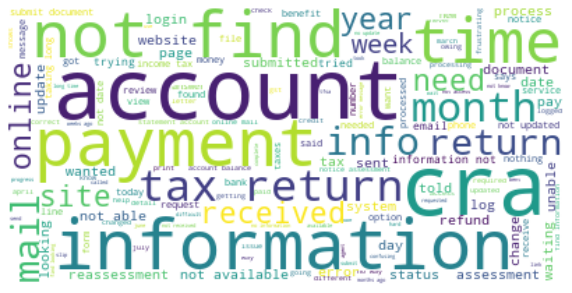

In [34]:
# whole text
text = ' '.join(dissat['Clean_dissatisfaction_reason']

# Generate a word cloud image
wordcloud = WordCloud(background_color="white" , max_font_size=60, contour_width=3, contour_color='steelblue').generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
lda_model = lda(num_topics = 4)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=dissat['Clean_dissatisfaction_reason'].apply(lambda x: x.split()), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

vis = vis_lda(lda_model)
vis


Perplexity:  -6.92620178585968

Coherence Score:  0.29874986548387616


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.334932  0.060441       1        1  37.870064
0     -0.190590  0.214398       2        1  25.083336
1     -0.074524 -0.303876       3        1  24.451962
2     -0.069818  0.029037       4        1  12.594642, topic_info=            Term         Freq        Total Category  logprob  loglift
7            not  2614.000000  2614.000000  Default  30.0000  30.0000
58            no   494.000000   494.000000  Default  29.0000  29.0000
72           tax   494.000000   494.000000  Default  28.0000  28.0000
4           find   618.000000   618.000000  Default  27.0000  27.0000
36       account   602.000000   602.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
920     terrible    37.063934    37.878708   Topic4  -4.9219   2.0502
689     question    32.811066    33.532928   Topic4  -5.0438   2.0501
404      unclear    32.934792    33.686790   Topic4  -5.0400   2.0493
212   disability    32.822960    33.576874   Topic4  -5.0434   2.0492
56   explanation    30.871447    31.608793   Topic4  -5.1047   2.0483

[159 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.995470        2
176       2  0.998556     2017
47        1  0.989064     2018
1         2  0.992666        3
342       3  0.996686     able
...     ...       ...      ...
252       1  0.989420  website
252       2  0.007915  website
302       2  0.995827    weeks
217       2  0.998490     year
543       2  0.994743    years

[138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [38]:
#best coh score: (only change num of topics)
scores = []
for n_topic in range(2,20):
    
    lda_model = lda(num_topics = n_topic)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=dissat['Clean_dissatisfaction_reason'].apply(lambda x: x.split()), dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    scores.append(coherence_lda)

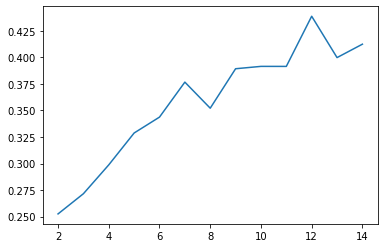

In [40]:
plt.plot(range(2,20), scores)
plt.show()

In [1]:
test = dissat['dissatisfaction_reason'].apply(spacy_tokenizer)
test[:10]

NameError: name 'dissat' is not defined

In [32]:
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import re
import unidecode

#import warnings

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=DeprecationWarning)

stop_words = set(stopwords.words('english') + stopwords.words('french'))

lemmer = WordNetLemmatizer()

def preprocess(x):
    # Lower case
    x = x.lower()
    
    # Remove punctuation
    x = re.sub(r'[^\w\s]', '', x)
    
    # Remove non-unicode
    x = unidecode.unidecode(x)
    
    # Remove numbers
    x = re.sub(r'\d+', '', x)
    
    # Remove stopwords and lemmatize
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    return ' '.join(x) 

dissat['clean'] = dissat['dissatisfaction_reason'].apply(preprocess)

In [33]:
dissat.iloc[0,:].clean


'couldnt find gst assessment logged outtimed setupprinted blank pagesays one page printed printed page blank url'

In [34]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01, 
                             max_features=1000, ngram_range=[1,3])
dtm = vectorizer.fit_transform(dissat['clean'])
print(dtm.shape)

(4169, 222)


In [35]:
vectorizer.get_feature_names()[:20]

['able',
 'access',
 'account',
 'account balance',
 'address',
 'adjustment',
 'agent',
 'ago',
 'also',
 'always',
 'amount',
 'answer',
 'april',
 'assessment',
 'available',
 'back',
 'balance',
 'bank',
 'benefit',
 'call']

In [36]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=12,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=200, 
                                      learning_method='batch', 
                                      random_state=123,
                                      n_jobs=2,
                                      verbose=0)
lda_output = lda_model.fit(dtm)

# Log Likelyhood: Higher the better
ll = lda_model.score(dtm)

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
perp = lda_model.perplexity(dtm)

In [37]:
# Theta = document-topic matrix
# Beta = components_ = topic-term matrix
theta = pd.DataFrame(lda_model.transform(dtm))
beta = pd.DataFrame(lda_model.components_)

In [38]:
# Build Topic Summary
feature_names = vectorizer.get_feature_names()
weight = theta.sum(axis=0)
support50 = (theta > 0.5).sum(axis=0)
support10 = (theta > 0.1).sum(axis=0)
termss = list()
for topic_id, topic in enumerate(lda_model.components_):
    terms = " ".join([feature_names[i] for i in topic.argsort()[:-6 - 1:-1]])
    termss.append(terms)
topic_summary = pd.DataFrame({'TopicID': range(0, len(termss)), "Support50": support50, "Support10": support10, "Weight": weight, "Terms": termss})

In [39]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 0)
topic_summary

,TopicID,Support50,Support10,Weight,Terms
0,0,254,726,393.656058,date cant phone answer call question
1,1,394,798,478.017675,document error submit log time page
2,2,237,612,360.491188,month still reassessment ago week waiting
3,3,137,532,295.730494,money know like owe cra say
4,4,146,421,271.588243,long taking take process time taking long
5,5,311,762,435.283598,return tax return tax status processed submitted
6,6,58,346,213.164306,income slip never income tax tax refund
7,7,180,606,331.387767,benefit updated child looking information payment
8,8,187,554,310.689247,information website available tfsa contribution difficult
9,9,182,574,328.798480,find could could find unable information find information


In [41]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, dtm, vectorizer, mds="tsne")

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1        5.310529  171.049652       1        1  12.020674
5      136.304657   23.800941       2        1  10.989538
0      101.190552  -84.985191       3        1   9.238378
10    -106.824867  148.841736       4        1   9.217884
11     -44.365761   78.632721       5        1   9.025254
2       43.884090   73.474022       6        1   8.934762
7      114.093971  135.933029       7        1   7.665021
9     -119.727142  -72.077179       8        1   7.482689
3      -49.518208   -9.617325       9        1   7.185562
8     -141.938736   40.055210      10        1   6.702829
4       38.731544  -14.776019      11        1   6.474852
6      -10.944340 -107.193344      12        1   5.062556, topic_info=            Term        Freq       Total Category  logprob  loglift
104         long   82.000000   82.000000  Default  30.0000  30.0000
36         could  119.000000  119.000000  Default  29.0000  29.0000
65          find  168.000000  168.000000  Default  28.0000  28.0000
158       return  148.000000  148.000000  Default  27.0000  27.0000
82        income   51.000000   51.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
10        amount    2.848959   52.624980  Topic12  -5.1383   0.0671
158       return    4.010802  148.192772  Topic12  -4.7963  -0.6262
164          see    3.002109   61.898476  Topic12  -5.0860  -0.0429
85   information    3.330770  207.255180  Topic12  -4.9821  -1.1474
2        account    3.251679  168.275057  Topic12  -5.0061  -0.9631

[475 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.214490  able
0         2  0.042898  able
0         3  0.114395  able
0         4  0.128694  able
0         5  0.114395  able
...     ...       ...   ...
221       4  0.113939   yet
221       6  0.211601   yet
221       7  0.048831   yet
221       9  0.065108   yet
221      10  0.325540   yet

[931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 11, 12, 3, 8, 10, 4, 9, 5, 7])